In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"
import keras

In [2]:
keras.utils.set_random_seed(15151515)

In [3]:
df_train = pd.read_csv('data/tr80.csv')
df_test = pd.read_csv('data/tt20.csv')

In [4]:
df_train.describe()

,Unnamed: 0,ID,CLASS,B7_1,B7_2,B7_3,B7_4,B7_5,B7_6,B7_7,...,B4_3,B4_4,B4_5,B4_6,B4_7,B4_8,B4_9,B4_10,B4_11,B4_12
count,12140.000000,12140.000000,12140.000000,7363.000000,4313.000000,11898.000000,11906.000000,11907.000000,12109.000000,12134.000000,...,11898.000000,11906.000000,11907.000000,12109.000000,12134.000000,12130.000000,12137.000000,11813.000000,11445.000000,4055.000000
mean,6069.500000,7619.770181,8.340857,1608.827889,1720.006086,1510.175408,1845.876953,2613.479634,3405.248679,3432.516565,...,904.410846,943.534499,879.852440,866.655752,936.175972,947.397918,1005.228640,987.131508,920.339428,1087.467263
std,3504.660469,4445.453009,5.599224,1235.039249,1249.205711,776.402814,858.231710,1202.509465,1232.234781,1413.421517,...,519.929347,523.610878,556.097036,546.556647,636.263642,573.896767,534.294807,547.096558,681.492656,1299.846852
min,0.000000,2.000000,1.000000,1.000000,1.000000,13.000000,28.000000,88.000000,84.000000,99.000000,...,31.000000,79.000000,80.000000,111.000000,91.000000,55.000000,72.000000,1.000000,1.000000,1.000000
25%,3034.750000,3780.750000,3.000000,868.500000,1073.500000,949.125000,1200.000000,1648.500000,2603.000000,2421.000000,...,595.000000,636.000000,500.750000,529.000000,469.000000,554.125000,688.500000,659.000000,530.000000,406.500000
50%,6069.500000,7596.500000,7.000000,1327.000000,1469.000000,1424.500000,1774.000000,2536.500000,3433.000000,3260.000000,...,819.500000,837.250000,785.000000,746.000000,740.000000,856.000000,926.500000,896.000000,766.500000,717.000000
75%,9104.250000,11439.250000,11.000000,1936.500000,1965.500000,1956.000000,2388.750000,3444.000000,4235.000000,4483.000000,...,1079.375000,1116.000000,1094.000000,1054.000000,1258.000000,1216.000000,1209.000000,1188.000000,1111.000000,1237.000000
max,12139.000000,30219.000000,40.000000,13860.000000,11126.000000,6794.000000,9689.000000,7901.000000,7689.000000,11556.000000,...,7100.000000,9752.000000,6280.000000,9896.000000,6088.000000,6484.000000,6456.000000,15808.000000,10416.000000,11632.000000


In [5]:
bands = set()
dates = set()
for column in df_train.columns:
    if not column.startswith("B"):
        continue

    parts = column.split('_')
    if len(parts) != 2:
        continue

    if parts[0] not in bands:
        bands.add(parts[0])

    if parts[1] not in dates:
        dates.add(int(parts[1]))

bands = list(bands)
dates = list(dates)

bands.sort()
dates.sort()
dates = dates[3:-3]

drop_dates = [1, 2, 3, 10, 11, 12]

for date in drop_dates:
    for band in bands:
        df_train = df_train.drop(columns=[f"{band}_{date}"])
        df_test = df_test.drop(columns=[f"{band}_{date}"])

df_train = df_train.dropna()
df_test = df_test.dropna()

for band in bands:
    for date in dates:
        df_train[f"{band}_{date}"] = df_train[f"{band}_{date}"].fillna(20000) / 10000
        df_test[f"{band}_{date}"] = df_test[f"{band}_{date}"].fillna(20000) / 10000

df_train = df_train[df_train.groupby("CLASS")["CLASS"].transform('count').ge(20)]
df_test = df_test[df_test.groupby("CLASS")["CLASS"].transform('count').ge(20)]

In [6]:
df_train.shape

(11557, 76)

In [7]:
print(f"Bands count: {len(bands)}")
print(bands)

print(f"Dates count: {len(dates)}")
print(dates)

Bands count: 12
['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
Dates count: 6
[4, 5, 6, 7, 8, 9]


In [8]:
train_classes = df_train["CLASS"].unique()
train_classes.sort()

print(len(train_classes))
print(train_classes)

21
[ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 21 26 34]


In [9]:
mapper = [None]*41
for i in range(len(train_classes)):
    mapper[train_classes[i]] = i

In [10]:
def pd_2_mts_XY(df):
    X = np.empty((df.shape[0], len(dates), len(bands)))
    Y = np.zeros((df.shape[0], len(train_classes)))

    counter = 0
    for _, row in df.iterrows():
        for date_i in range(len(dates)):
            for band_i in range(len(bands)):
                X[counter, date_i, band_i] = row[f"{bands[band_i]}_{dates[date_i]}"]
        
        Y[counter, mapper[int(row["CLASS"])]] = 1
        counter += 1

    return X, Y


In [11]:
train_X, train_Y = pd_2_mts_XY(df_train)

test_X, test_Y = pd_2_mts_XY(df_test)

In [12]:
train_X.shape

(11557, 6, 12)

In [13]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(len(dates), len(bands))),
        keras.layers.Dropout(0.2),
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.GRU(32),
        keras.layers.Dense(len(train_classes), activation="softmax")
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 6, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 6, 64)          │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,077 (97.96 KB)

 Trainable params: 25,077 (97.96 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy", "f1_score", "precision", "recall"],
)

In [15]:
history = model.fit(
    train_X,
    train_Y,
    batch_size=128,
    epochs=50,
    verbose=1,
    validation_data=(test_X, test_Y)
)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - categorical_accuracy: 0.1716 - f1_score: 0.0258 - loss: 2.7242 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_categorical_accuracy: 0.2042 - val_f1_score: 0.0168 - val_loss: 2.3321 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - categorical_accuracy: 0.2956 - f1_score: 0.0794 - loss: 2.2948 - precision: 0.3321 - recall: 0.0131 - val_categorical_accuracy: 0.5151 - val_f1_score: 0.1745 - val_loss: 1.5171 - val_precision: 0.7904 - val_recall: 0.1224
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - categorical_accuracy: 0.4828 - f1_score: 0.1931 - loss: 1.6533 - precision: 0.7348 - recall: 0.1543 - val_categorical_accuracy: 0.6611 - val_f1_score: 0.3130 - val_loss: 1.1344 - val_precision: 0.7991 - val_recall: 0.4188
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - categorical_accuracy: 0.5586 - f1_score: 0.2637 - loss: 1.4166 - precision: 0.6919 - recall: 0.3449 - val_

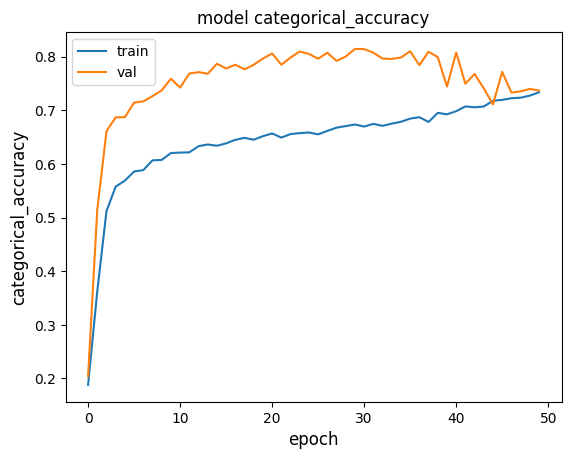

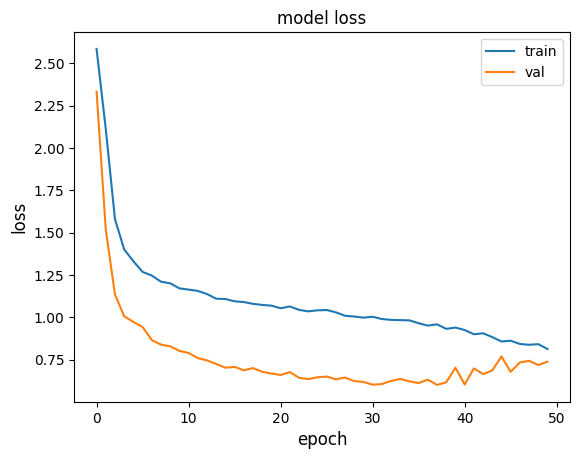

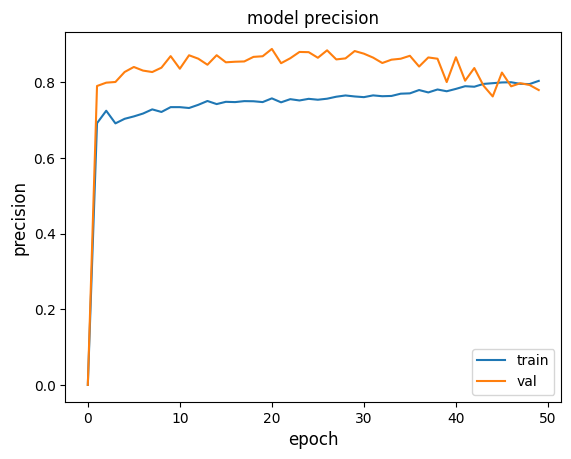

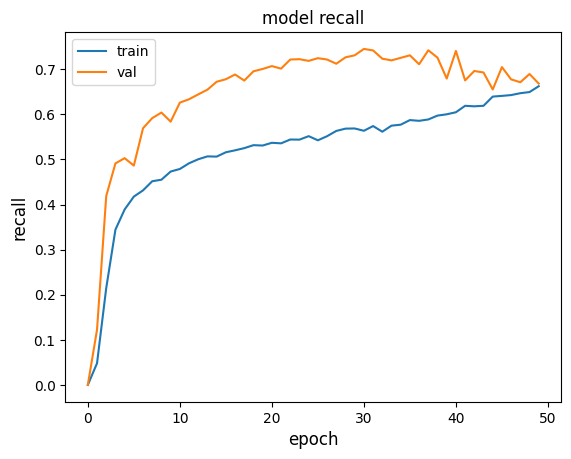

In [16]:
metrics = ["categorical_accuracy", "loss", "precision", "recall"]

for metric in metrics:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.show()
    plt.close()

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [18]:
pred_train = np.argmax(model.predict(train_X), axis=1)
pred_test = np.argmax(model.predict(test_X), axis=1)

362/362 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [19]:
print(classification_report(np.argmax(train_Y, axis=1), pred_train))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       415
           1       0.63      0.96      0.76      2194
           2       0.97      0.18      0.30       382
           3       0.00      0.00      0.00        63
           4       0.53      0.98      0.69      1388
           5       1.00      0.03      0.06        62
           6       0.95      0.57      0.71      1544
           7       0.48      0.12      0.19       631
           8       0.87      0.99      0.92       632
           9       0.67      0.85      0.75      1624
          10       0.96      0.71      0.82       188
          11       0.99      0.98      0.99       568
          12       0.70      0.78      0.74       279
          13       0.68      0.05      0.09       685
          14       0.60      0.03      0.05       107
          15       0.00      0.00      0.00        81
          16       0.75      0.02      0.04       276
          17       0.87    

e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
print(classification_report(np.argmax(test_Y, axis=1), pred_test))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        96
           1       0.68      0.96      0.79       544
           2       1.00      0.18      0.31        88
           4       0.58      0.98      0.73       340
           6       0.97      0.58      0.73       380
           7       0.74      0.21      0.32       150
           8       0.88      0.99      0.93       146
           9       0.72      0.89      0.80       394
          10       1.00      0.75      0.86        40
          11       0.99      0.98      0.99       136
          12       0.78      0.82      0.80        60
          13       0.81      0.08      0.15       160
          16       0.75      0.05      0.10        57
          17       0.78      0.46      0.58        67
          18       0.00      0.00      0.00        21

    accuracy                           0.74      2679
   macro avg       0.77      0.59      0.60      2679
weighted avg       0.78   

e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


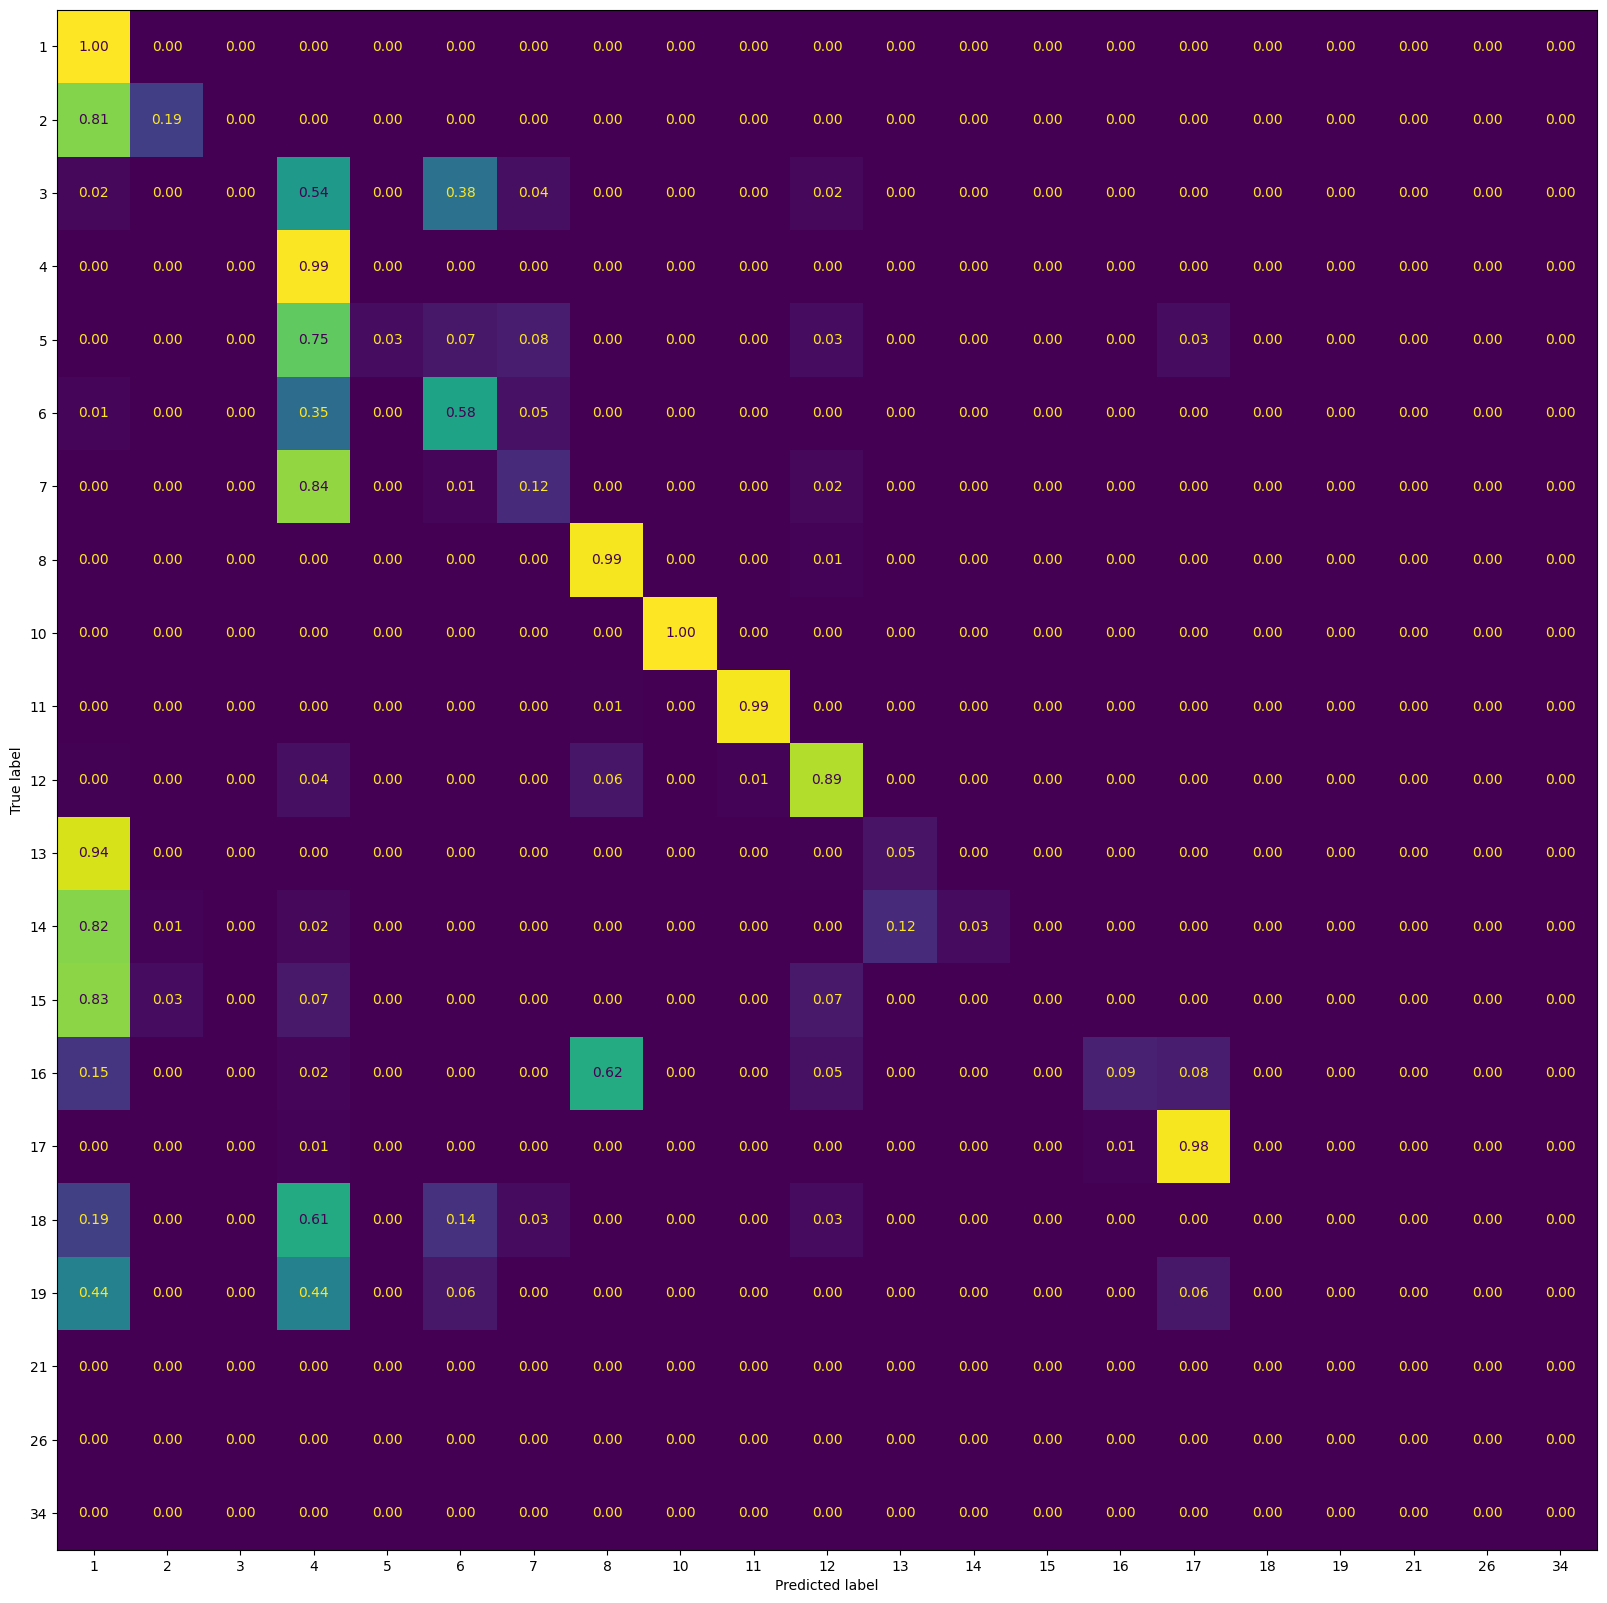

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(np.argmax(train_Y, axis=1), pred_train, normalize='true', labels=train_classes, display_labels=train_classes, values_format=".2f", ax=ax, colorbar=False)

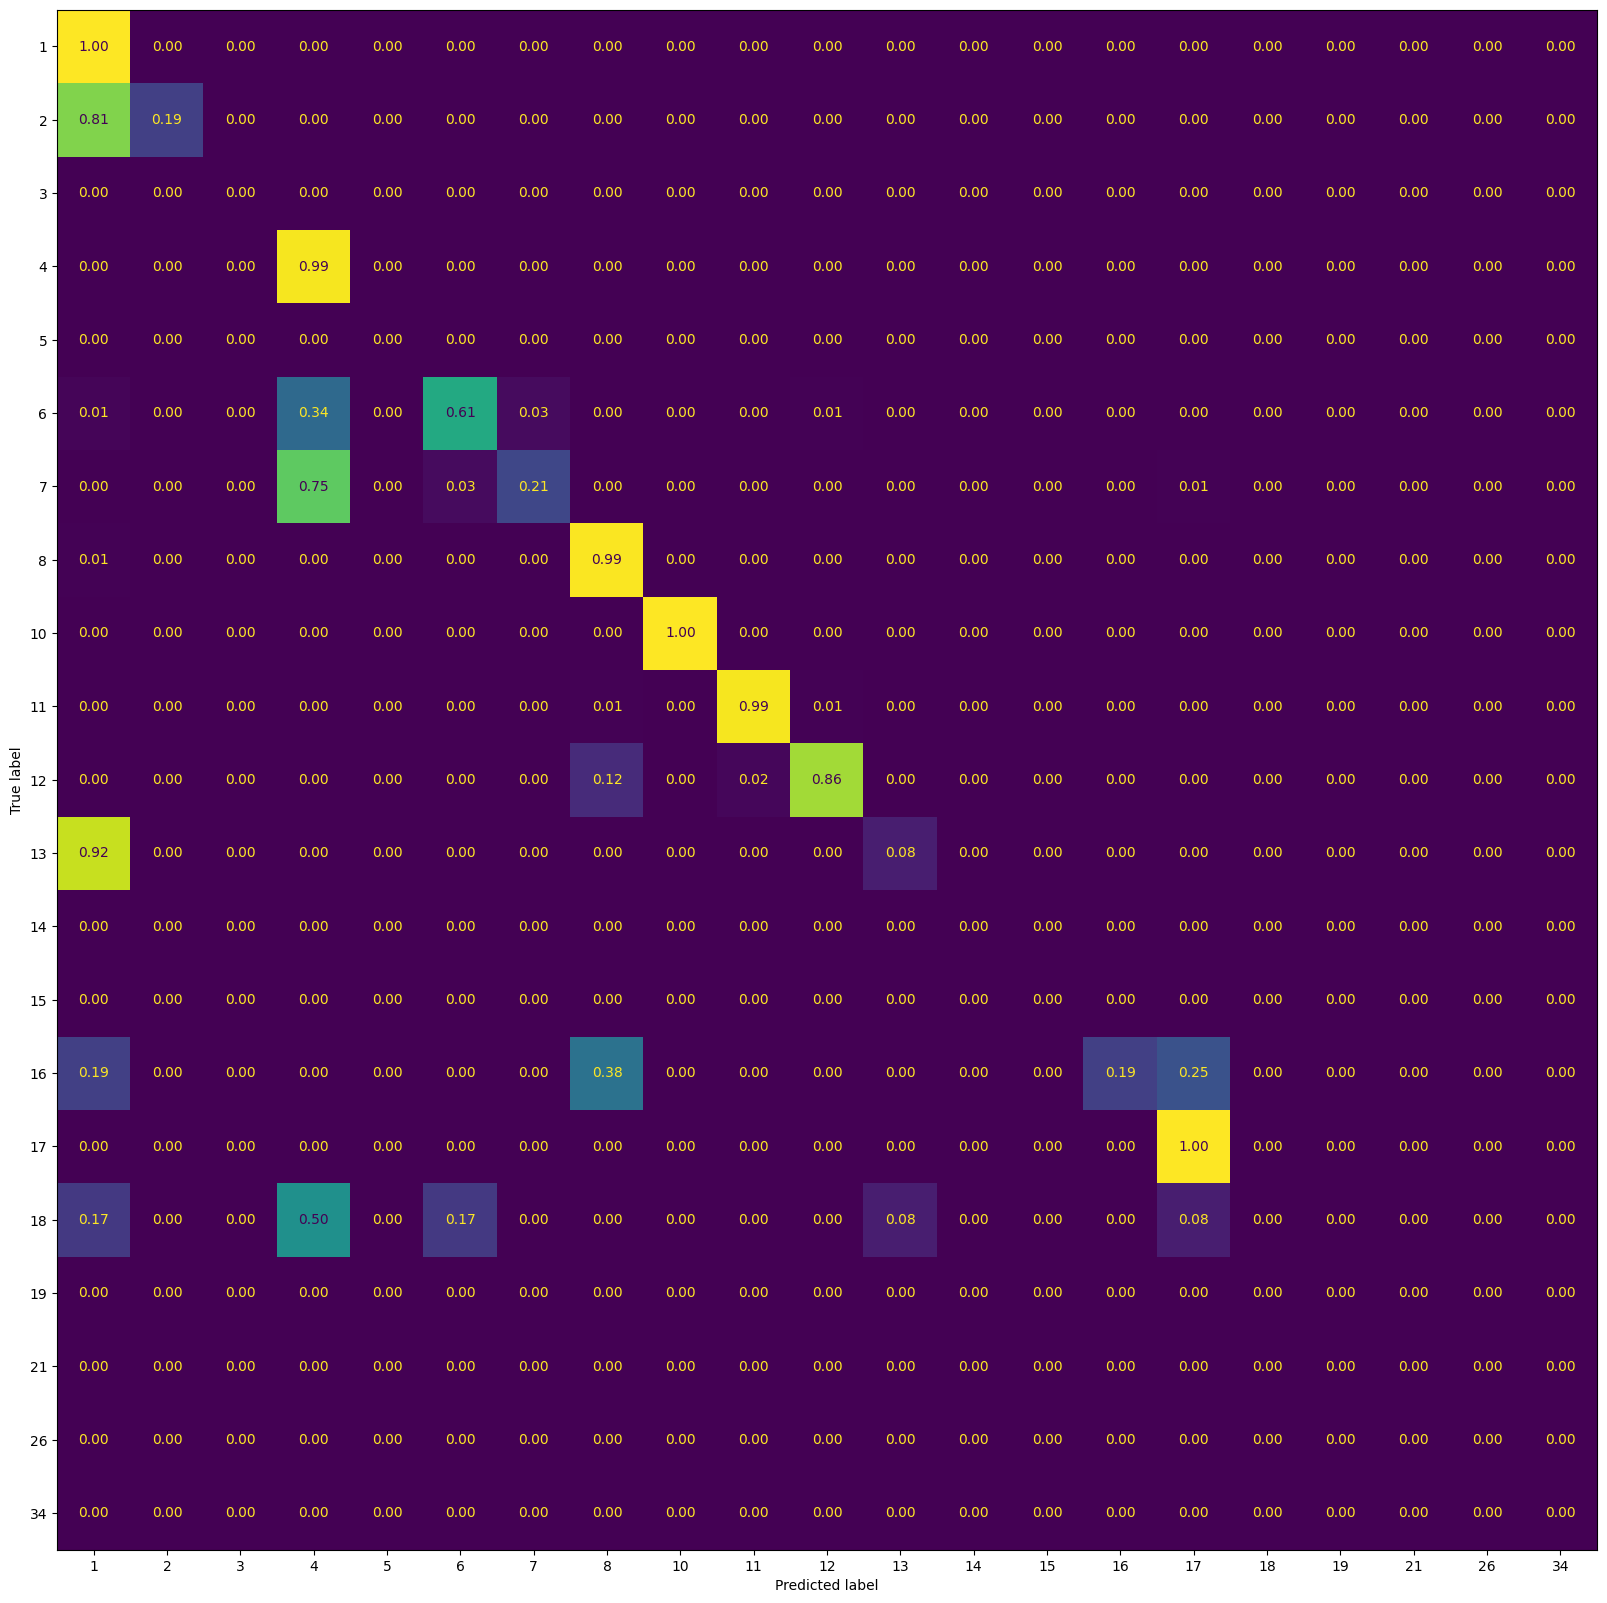

In [22]:
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(np.argmax(test_Y, axis=1), pred_test, normalize='true', labels=train_classes, display_labels=train_classes, values_format=".2f", ax=ax, colorbar=False)